# Task 1: Genes
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [96]:
# Load libraries
import os
import warnings
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, mutual_info_score, f1_score, roc_auc_score, silhouette_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

from fcmeans import FCM

from tqdm import tqdm

In [2]:
# Configure libraries
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Set location of data directory
data_path = os.path.join("..","Data-PR-As2","Genes")

In [4]:
# Path for saving figures
figure_path = "Figures"
if not os.path.isdir(figure_path):
    os.mkdir(figure_path)

def save_plot(name):
    if name:
        plt.savefig(os.path.join(figure_path, name + ".pdf"), bbox_inches="tight")

In [5]:
# Load dataset (this takes a while)
df = pd.read_csv(os.path.join(data_path, "data.csv"))
df_labels = pd.read_csv(os.path.join(data_path, "labels.csv"))

In [6]:
# Remove first columns as they just contain row names
df = df.iloc[:, 1:]
df_labels = df_labels.iloc[:, 1:]

## Data Analysis

In [7]:
# Dimensions of data
n_observations, n_features = df.shape
print("# observations:",n_observations," # features:", n_features)
classes = df_labels["Class"].unique()
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

# observations: 801  # features: 20531
There are 5 classes: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


In [8]:
def plot_class_freq(y, fig_name=None):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    ax.bar_label(ax.containers[0])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    save_plot(fig_name)
    plt.show()

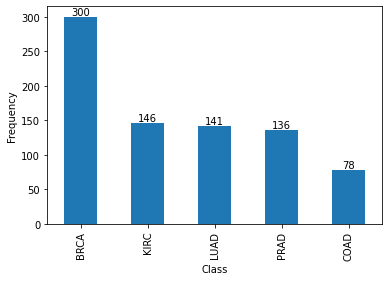

In [9]:
# Inspect frequency of class labels
plot_class_freq(df_labels, fig_name="imbalanced")

Min value: 0.0  Max value: 20.7788287118


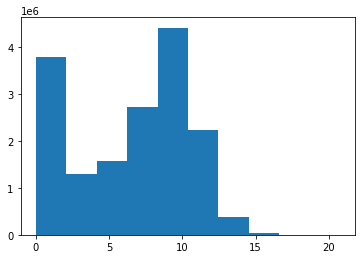

In [10]:
# Distribution of data across all features
df.stack().hist(grid=False)
df_np = df.to_numpy()
print("Min value:", df_np.min(), " Max value:", df_np.max())

In [11]:
# mean, std, min and max values vary between genes
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [12]:
print("Are there duplicate rows in the dataset?", any(df.duplicated()))

Are there duplicate rows in the dataset? False


In [156]:
palette = dict(zip(classes, sns.color_palette(n_colors=n_classes)))

def plot_tsne(x, y, fig_name=None, lim=60, palette=palette, title=None):
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
    X_tsne = tsne.fit_transform(x)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue="Class", palette=palette, data=y)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    if title:
        plt.title(title)
        fig_name = title.replace(" ", "_")
    save_plot(fig_name)
    plt.show()

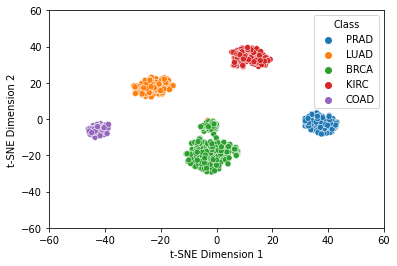

In [20]:
# Visualize multidimensional data
plot_tsne(df, df_labels, fig_name="imbalanced_tsne")

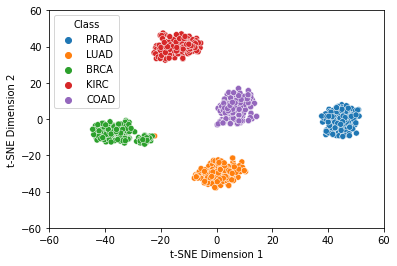

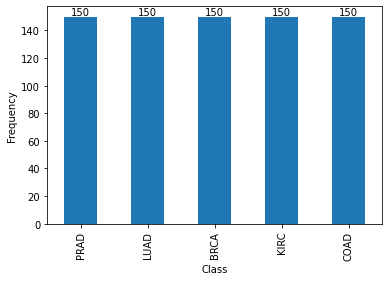

In [21]:
# Balance dataset

# remove 150 from BRCA
prad_idxs = df_labels.index[df_labels["Class"] == "BRCA"]
remove_indices = np.random.choice(prad_idxs, size=150, replace=False)
adjusted_df = df.drop(remove_indices)
adjusted_df_labels = df_labels.drop(remove_indices)

# over sample rest of classes
sm = SMOTE(sampling_strategy="not majority", k_neighbors=5, random_state=RANDOM_STATE)
adjusted_df, adjusted_df_labels = sm.fit_resample(adjusted_df, adjusted_df_labels)

plot_tsne(adjusted_df, adjusted_df_labels, fig_name="balanced_tsne")
plot_class_freq(adjusted_df_labels) # double check

## Feature Selection / Dimension Reduction

In [22]:
# Create hold-out set
X, y = adjusted_df, adjusted_df_labels
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### PCA

In [23]:
def plot_pca_comp_variance(x, comp, fig_name=None):
    pca = PCA(n_components=comp)
    pca.fit(x)
    plt.plot(list(range(1, comp + 1)), pca.explained_variance_ratio_, "o-", linewidth=2)
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    save_plot(fig_name)
    plt.show()

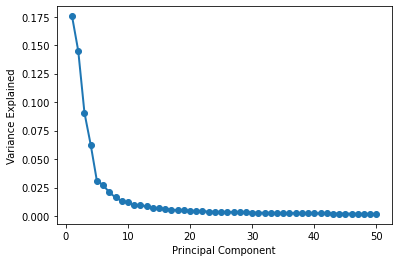

In [24]:
plot_pca_comp_variance(X_train_bal, comp=50, fig_name="scree")

In [91]:
def try_pca(components, x_train, y_train, x_test, y_test, model, normalizer, unsuper):
    scores = []
    
    if normalizer:
        x_train = normalizer.fit_transform(x_train)
        x_test = normalizer.transform(x_test)
        
    if unsuper:
        y_test = (y_test.to_numpy()).flatten()
    
    for n in tqdm(components):
        pca = PCA(n_components=n)
            
        X_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        model.fit(X_train_pca) if unsuper else model.fit(X_train_pca, y_train)
        y_pred = model.predict(x_test_pca)
        
        score_func = mutual_info_score if unsuper else accuracy_score
        scores.append(score_func(y_test, y_pred))
        
    return scores

def find_best_pca(x, y, model, normalizer, label, color, linestyle, min_comp=2, max_comp=10, split=0.2, unsuper=False):
    components = list(range(min_comp, max_comp + 1))
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=RANDOM_STATE)
    scores = try_pca(components, X_train, y_train, X_test, y_test, model, normalizer, unsuper)
    
    best_n_components = np.argmax(scores) + min_comp
    label = f"{label}  (min comp = {best_n_components})"
    plt.plot(components, scores, label=label, color=color, linestyle=linestyle)
    plt.xlabel("Number of Components used")
    plt.ylabel("Mutual Info Score" if unsuper else "Model Accuracy")
    plt.legend()
    
    return best_n_components

In [26]:
models = [(LogisticRegression(random_state=RANDOM_STATE), "LogReg", "blue"), 
          (GaussianNB(), "NB", "red"),
          (KNeighborsClassifier(n_neighbors=3), "KNN", "orange")
         ]
norms = [(None, "", "solid"), (StandardScaler, "Norm", "dotted")] #, (MinMaxScaler, "MinMax", "dashed")]

100%|█████████████████████████████████████████████| 9/9 [00:05<00:00,  1.59it/s]


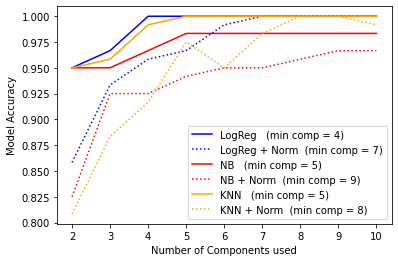

In [89]:
comps = []

for m, m_name, color in models:
    for n, n_name, style in norms:
        normalizer = n() if n else None
        name = m_name + (" + " if n_name else " ") + n_name  
        comps.append(find_best_pca(X_train_bal, y_train_bal, m, normalizer, name, color, style))

save_plot("best_pca")
plt.show()

In [28]:
pca_n_comp_logreg = comps[0]
pca_n_comp_nb = comps[2]
pca_n_comp_knn = comps[4]

### Mutual Information

In [29]:
def rank_features(x, y):
    selector = SelectKBest(mutual_info_classif, k="all")
    selector.fit(x, y)
    feature_importance = np.flip(np.argsort(selector.scores_))
    return feature_importance

In [80]:
def try_mutual_info(top_n_feat, top_features, x_train, y_train, x_test, y_test, 
                    model, normalizer, unsuper, score_func=accuracy_score):
    scores = []
    
    if unsuper:
        y_test = (y_test.to_numpy()).flatten()
    
    if normalizer:
        x_train = pd.DataFrame(normalizer.fit_transform(x_train))
        x_test = pd.DataFrame(normalizer.transform(x_test))
    
    for i in tqdm(top_n_feat):
        best_cols = top_features[:i]
                
        reduced_x_train = x_train.iloc[:,best_cols]
        reduced_x_test = x_test.iloc[:,best_cols]
        model.fit(reduced_x_train.to_numpy()) if unsuper else model.fit(reduced_x_train, y_train)
        y_pred = model.predict(reduced_x_test.to_numpy())
        
        score_func = mutual_info_score if unsuper else accuracy_score
        scores.append(score_func(y_test, y_pred))
    
    return scores

def find_best_mutual_info(features_ranked, x, y, model, normalizer, label, color, linestyle, unsuper=False,
                          min_n_feat=2, top_n_feat=12, split=0.2):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=RANDOM_STATE)   
    
    top_n_feat = list(range(min_n_feat, top_n_feat + 1))
    scores = try_mutual_info(top_n_feat, features_ranked, X_train, y_train, X_test, y_test, model, normalizer, unsuper)
    min_feat = np.argmax(scores) + min_n_feat
    
    plt.plot(top_n_feat, scores, label=f"{label}  (min feat = {min_feat})", color=color, linestyle=linestyle)
    plt.xlabel("Number of Top N Features used by Model")
    plt.ylabel("Mutual Info Score" if unsuper else "Model Accuracy")
    plt.legend()
    
    return features_ranked[:min_feat]

In [31]:
# This takes a while
features_ranked = rank_features(X_train_bal, y_train_bal)

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 204.92it/s]


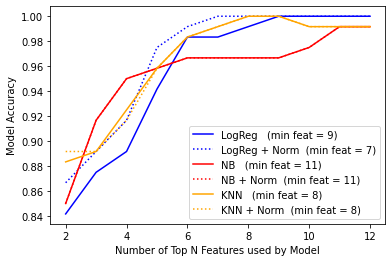

In [79]:
num_feats = []

for m, m_name, color in models:
    for n, n_name, style in norms:
        normalizer = n() if n else None
        name = m_name + (" + " if n_name else " ") + n_name
        num_feats.append(find_best_mutual_info(features_ranked, X_train_bal, y_train_bal, m, normalizer, name, color, style)) 

save_plot("best_feats")
plt.show()

In [38]:
mi_feat_logreg = num_feats[1]
mi_feat_nb = num_feats[2]
mi_feat_knn = num_feats[4]

## Classification (K-fold)

In [40]:
def reduce_data(data_manip, X_train, X_test):
    if isinstance(data_manip, PCA):
        X_train = data_manip.fit_transform(X_train)
        X_test = data_manip.transform(X_test)
    elif isinstance(data_manip, np.ndarray):
        X_train = X_train.iloc[:,data_manip]
        X_test = X_test.iloc[:,data_manip]
    return X_train, X_test

def f1_score_multi(y_test, y_pred):
    return f1_score(y_test, y_pred, average="macro")

def cross_val(model, x, y, data_manip=None, normalizer=None, splits=5, metrics=[accuracy_score]):
    times = np.zeros((splits, 2))
    kf = StratifiedKFold(n_splits=splits)
    scores = np.zeros((splits, len(metrics)))
    
    for i_fold, (train_index, test_index) in enumerate(tqdm(kf.split(x, y), total=splits)):
        X_train, X_test = df.iloc[train_index,:], df.iloc[test_index,:]
        y_train, y_test = df_labels.iloc[train_index,:], np.array(df_labels.iloc[test_index,:]).ravel()
        
        X_train, X_test = reduce_data(data_manip, X_train, X_test)
        
        if normalizer:
            X_train = normalizer.fit_transform(X_train)
            X_test = normalizer.transform(X_test)
        
        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()
        
        start_test = time.time()
        y_pred = model.predict(X_test)
        end_test = time.time()
        
        times[i_fold,:] = [end_train - start_train, end_test - start_test]
        
        for i, m in enumerate(metrics):
            scores[i_fold, i] = m(y_test, y_pred)

    times = times.mean(axis=0)
    scores = scores.mean(axis=0)
    
    print(f"Model: {model}, with {type(data_manip).__name__}")
    print("Avg Training Time: {} \nAvg Testing Time:{}".format(*times))
    print(": {}\n".join([x.__name__ for x in metrics] + [""]).format(*scores))
    
    #return time, scores


In [41]:
X_cross = X_train_bal
Y_cross = y_train_bal

model = LogisticRegression()
cross_val(model, X_cross, Y_cross)
cross_val(model, X_cross, Y_cross, PCA(n_components=pca_n_comp_logreg))
cross_val(model, X_cross, Y_cross, mi_feat_logreg, StandardScaler())

model = GaussianNB()
cross_val(model, X_cross, Y_cross)
cross_val(model, X_cross, Y_cross, PCA(n_components=pca_n_comp_nb))
cross_val(model, X_cross, Y_cross, mi_feat_nb)

model = KNeighborsClassifier(n_neighbors=3)
cross_val(model, X_cross, Y_cross)
cross_val(model, X_cross, Y_cross, PCA(n_components=pca_n_comp_knn))
cross_val(model, X_cross, Y_cross, mi_feat_knn)


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.81s/it]


Model: LogisticRegression(), with NoneType
Avg Training Time: 4.579636430740356 
Avg Testing Time:0.19466886520385743
accuracy_score: 0.9966666666666667



100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


Model: LogisticRegression(), with PCA
Avg Training Time: 0.02513012886047363 
Avg Testing Time:0.00011820793151855469
accuracy_score: 0.9883333333333333



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 23.66it/s]


Model: LogisticRegression(), with ndarray
Avg Training Time: 0.006943607330322265 
Avg Testing Time:8.783340454101562e-05
accuracy_score: 0.9883333333333333



100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.72it/s]


Model: GaussianNB(), with NoneType
Avg Training Time: 0.1940941333770752 
Avg Testing Time:0.1441193103790283
accuracy_score: 0.8133333333333332



100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]


Model: GaussianNB(), with PCA
Avg Training Time: 0.0013260841369628906 
Avg Testing Time:0.0003424644470214844
accuracy_score: 0.9883333333333333



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 26.78it/s]


Model: GaussianNB(), with ndarray
Avg Training Time: 0.0021738529205322264 
Avg Testing Time:0.001075887680053711
accuracy_score: 0.985



100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


Model: KNeighborsClassifier(n_neighbors=3), with NoneType
Avg Training Time: 0.10291490554809571 
Avg Testing Time:0.26909308433532714
accuracy_score: 0.9983333333333334



100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


Model: KNeighborsClassifier(n_neighbors=3), with PCA
Avg Training Time: 0.0019999027252197267 
Avg Testing Time:0.0037522315979003906
accuracy_score: 0.99



100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 24.16it/s]

Model: KNeighborsClassifier(n_neighbors=3), with ndarray
Avg Training Time: 0.002660036087036133 
Avg Testing Time:0.004560708999633789
accuracy_score: 0.9916666666666666



## Clustering

100%|█████████████████████████████████████████████| 9/9 [00:05<00:00,  1.61it/s]


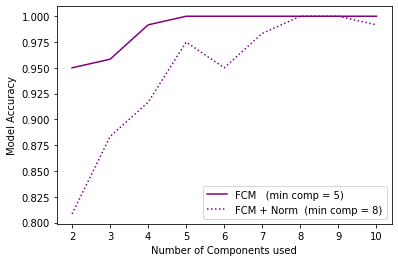

In [148]:
color = "purple"
model = FCM(n_clusters=5)
m_name = "FCM"
comps2 = []

for n, n_name, style in norms:
    normalizer = n() if n else None
    name = m_name + (" + " if n_name else " ") + n_name  
    comps2.append(find_best_pca(X_train_bal, y_train_bal, m, normalizer, name, color, style))

best_comp_cls = comps2[0]
save_plot("best_pca_cluster")

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 157.48it/s]


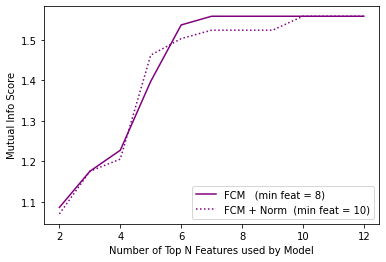

In [116]:
num_feats2 = []

for n, n_name, style in norms:
    normalizer = n() if n else None
    name = m_name + (" + " if n_name else " ") + n_name
    num_feats2.append(find_best_mutual_info(features_ranked, X_train_bal, y_train_bal, model, normalizer, name, color, style, unsuper=True))
    
best_feats_cls = num_feats2[0]
save_plot("best_feat_cluster")

In [160]:
# on original dataset
model.fit(X_train_bal.to_numpy())
x_test_org = X_test_bal.to_numpy()
y_pred_org = model.predict(x_test_org)

In [161]:
# mutual information
model.fit(X_train_bal.iloc[:,best_feats_cls].to_numpy())
x_test_mi = X_test_bal.iloc[:,best_feats_cls].to_numpy()
y_pred_mi = model.predict(x_test_mi)

In [162]:
# PCA
pca = PCA(n_components=best_comp_cls)
model.fit(pca.fit_transform(X_train_bal))
x_test_pca = pca.transform(X_test_bal)
y_pred_pca = model.predict(x_test_pca)

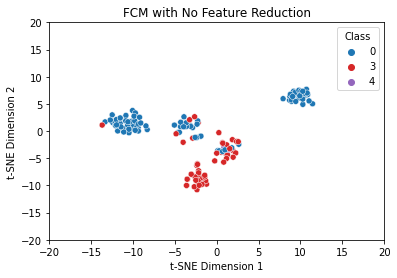

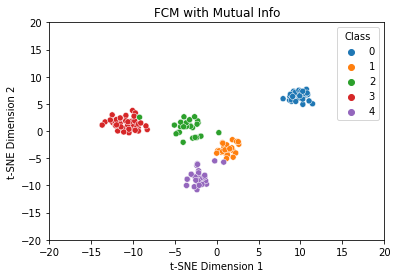

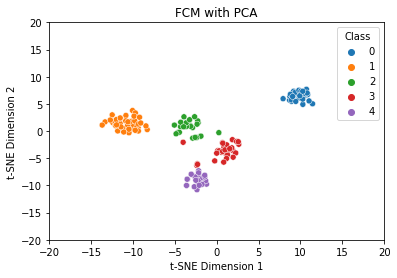

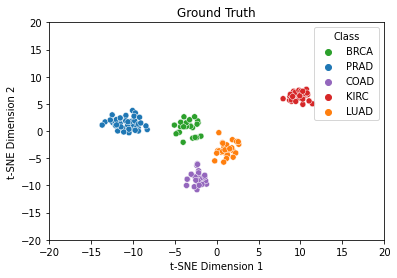

In [157]:
palette2 = dict(zip(list(range(0,n_classes)), sns.color_palette(n_colors=n_classes)))

lim=20
plot_tsne(X_test_bal, pd.DataFrame({"Class":y_pred_org}), lim=lim, palette=palette2, title="FCM with No Feature Reduction")
plot_tsne(X_test_bal, pd.DataFrame({"Class":y_pred_mi}), lim=lim, palette=palette2, title="FCM with Mutual Info")
plot_tsne(X_test_bal, pd.DataFrame({"Class":y_pred_pca}), lim=lim, palette=palette2, title="FCM with PCA")
plot_tsne(X_test_bal, y_test_bal, lim=lim, title="Ground Truth")

In [164]:
preds = [(y_pred_org, x_test_org, "Original"), (y_pred_mi, x_test_mi, "Mutual Info"), (y_pred_pca, x_test_pca, "PCA")]
y_test = y_test_bal.to_numpy().flatten()

for y_pred, x_test, name in preds:
    print(name)
    print(silhouette_score(x_test, y_pred))
    print(mutual_info_score(y_test, y_pred))
    print("---")

Original
0.11374770218537038
0.8547154700841818
---
Mutual Info
0.4994712993488001
1.4868359796516333
---
PCA
0.5860669174343538
1.4725089964241207
---


## Grid Search (broken fix)

In [47]:
parameters = {'n_neighbors':[1, 3, 5, 7], 'weights':('uniform', 'weights'), 'p': [1, 2], 'n_jobs': [-1], 'algorithm': ('ball_tree','kd_tree','brute')}
clf = GridSearchCV(KNeighborsClassifier(), parameters)
clf.fit(X_train_bal, y_train_bal)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'),
                         'n_jobs': [-1], 'n_neighbors': [1, 3, 5, 7],
                         'p': [1, 2], 'weights': ('uniform', 'weights')})

In [48]:
print(clf.best_params_)
print(pd.DataFrame(clf.cv_results_))

{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.299789      0.011612         0.629784        0.495687   
1        0.022394      0.000413         0.000000        0.000000   
2        0.319819      0.028325         0.422050        0.019348   
3        0.023159      0.002778         0.000000        0.000000   
4        0.324292      0.028901         0.399625        0.017705   
5        0.022949      0.002084         0.000000        0.000000   
6        0.299831      0.028370         0.379222        0.020835   
7        0.024199      0.003975         0.000000        0.000000   
8        0.287543      0.008542         0.364784        0.007886   
9        0.021183      0.000203         0.000000        0.000000   
10       0.284560      0.006238         0.362163        0.007812   
11       0.024236      0.003601         0.000000        0.000000   
12       0.312431      0.02

### Ensemble (broken)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_over, df_labels_over, test_size=0.2, random_state=RANDOM_STATE)

models = [(SVC(**clf.best_params_), "SVM"), (GaussianNB(), "Bayes"), (KNeighborsClassifier(**clf_cluster.best_params_), "KNN")]
predictions = pd.DataFrame()

for model, name in models:
    X_bag, y_bag = resample(X_train, y_train, replace=True, random_state=RANDOM_STATE)
    model.fit(X_bag, y_bag)
    y_pred = model.predict(X_test)
    predictions[name] = list(y_pred)

In [ ]:
bag_out = predictions.apply(pd.value_counts, axis=1).idxmax(axis=1)
accuracy_score(y_test, bag_out)